# Mean Error Analysis

In [261]:
EXPORT_LATEX = False

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

pd.set_option('display.precision', 2,
              'display.width', 300,
              'display.chop_threshold', 0.0001,
              'display.expand_frame_repr', False,
              'display.max_rows', None)

# DATA EXPORT PATHS
# ...data
PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
NAME_DATA_FILES = '*results.txt'
# ...LaTeX
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

lms_red = (204/255, 53/255, 56/255)

EVALUATIONS = ['base', 'em-iterations', 'min-distance', 'reflect-order', 'T60', 'noise', 'wd', 'var-fixed']
PARAMETERS = {'s':None, 'md':0.5, 'wd':1.2, 'T60':0.0, 'SNR':0, 'em':None, 'reflect-order':3, 'var-fixed':0, 'var-val':0.1}

DICT_SUMMARY = {'x1':'count',  # sample size
                'em':np.mean,  # em-iterations
                'T60':np.mean,
                'SNR':np.mean,
                'md':np.mean,
                'reflect-order':np.mean,
                'var-fixed':np.mean,
                'var-val':np.mean,
                'err-mean':np.mean,
                'percent-matched':np.mean}

DEFAULT_LINE_PLOT_ARGS = {'kind':'line',
                          'marker':'o',
                          'markersize':6,
                          'color':[lms_red, "orange", "black", "darkgrey", "blue", "magenta", "green", "yellow", "lightgray"]}

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)
    
def is_matched(x):
    ret = []
    for el in x:
        if str.lower(str(el))=="nan":
            ret.append(np.NaN)
        elif abs(el)>=0.1:
            ret.append(0)
        elif el==np.NaN:
            ret.append(np.Nan)
        else:
            ret.append(1)
    return ret

def round_to_two(x):
    ret = []
    for el in x:
        ret.append(round(x, 2))
    return ret

def ticks_restrict_to_integer(axis):
    """Restrict the ticks on the given axis to be at least integer,
    that is no half ticks at 1.5 for example.
    """
    from matplotlib.ticker import MultipleLocator
    major_tick_locs = axis.get_majorticklocs()
    if len(major_tick_locs) < 2 or major_tick_locs[1] - major_tick_locs[0] < 1:
        axis.set_major_locator(MultipleLocator(1))

def init_grid(spgrid: tuple, figsize: tuple):
    plt.subplots(spgrid[0],spgrid[1], figsize=figsize)
    ax = list()
    for i in range(1,spgrid[0]*spgrid[1]+1):
        ax.append(plt.subplot(spgrid[0],spgrid[1],i))
    i=0
    return ax, i
        
def adjust_y_axis(step_size, digits=0, min=None, max=None, ax=None):
    if isinstance(ax, type(None)):
        plt.axes()
    if ax.get_ylim()[1]<1:
        ax.set_ylim([0,1])
    start, end = ax.get_ylim()
    if not min: min=start
    if not max: max=round(end+step_size, digits)
    ax.set_yticks(np.arange(min, max, step_size))

def scatter_plot(df, xaxis='n-sources', yaxis='err-mean'):
    x = df[xaxis].values
    y = df[yaxis].values
    means = df.groupby([xaxis]).mean()[yaxis]
    medians = df.groupby([xaxis]).median()[yaxis]
    plt.scatter(x, y, alpha=0.1, c="gray")
    plt.scatter(means.index.values, means.values, alpha=1.0, c=lms_red, marker="o", linewidth="4", label="mean")
    plt.scatter(medians.index.values, medians.values, alpha=1.0, c="black", marker="_", linewidth="2", label="median")
    # plt.xticks(n-sources_range)
    adjust_y_axis(step_size=0.5, digits=2, min=0)
    plt.grid(True, axis='y')
    plt.xlabel("number of sources")
    plt.ylabel("mean localisation error (m)")
    l = plt.legend()
    if EXPORT_LATEX:
        tikz_save(PATH_SCATTER_PLOT, show_info=False)

def style_boxplot(boxplots, fig=None, axes=None):
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not fig: fig = boxplots[0][0].ax.get_figure()
    if not axes: axes = [boxplots[0][0].ax]
    for bp in boxplots:
        for key in bp[0].lines.keys():
            for item in bp[0].lines[key]:
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(lms_red)
                    item.set_markersize(7)
                if key=="medians":
                    item.set_color(lms_red)
                    item.set_linewidth(3)
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                else:
                    item.set_color(lms_red)
    if axes:
        for ax in axes:
            ax.set_title("")
#             ax.set_xlabel("number of sources")
#             ax.set_ylabel("mean localisation error (m)")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.grid(axis="x")
            ax.set_ylim([0, 2])
            ax.set_yticks(np.arange(0, 2.1, 0.2))
#             ax.set_xticks([2,3,4,5,6,7])
#             ticks_restrict_to_integer(ax.get_xaxis())
#             ax.get_xaxis().set_major_formatter("%0.2f")
    if fig:
        fig.suptitle('')

def style_line_plot(xlabel, ylabel, grid, ax=None):
    if isinstance(ax, type(None)):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(axis=grid)
    else:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(axis=grid)
        
def print_summary(df, verbose=True):
    print("DATA FROM: ", set(df["description"].values))
    summary = df.groupby('n-sources').agg(DICT_SUMMARY).rename(columns={'x1':'n', 'em':'em-iterations'})
    print(summary.transpose())
    for col in [x for x in PARAMETERS.keys() if x != "s"]:  # Print additional notes for these columns
        warn=False
        if df[col].min()!=df[col].max():
            col_values = df.pivot_table("x1", index=[col], columns=["n-sources"], aggfunc="count")
            if col_values.min().min()==col_values.max().max():
                n=col_values.min().min()
            else:
                if (col_values.min(axis=1).values-col_values.max(axis=1)).sum() != 0:
                    warn=True
                n = list(col_values.min(axis=1).values)
            print("NOTE: Data contains range of {col} ({values}, n={n})"
                  .format(col=col, values=[str(x) for x in list(col_values.index.values)], n=n))
            if warn and verbose:
                print("WARN: Unbalanced n_sources for '{}'. There may be a trial running at the moment!".format(col))
                print(col_values)
    print()  # empty line at the end
            
def parse_parameters(fname):
    ret = {'s':None, 'md':0.5, 'wd':1.2, 'T60':0.0, 'SNR':0, 'em':None, 'refl-ord':3, 'var-fixed':0, 'var-val':0.1}
    done=False
    s=0
    while not done:
        i = fname.find("_", s)
        i2 = fname.find("_", i+1)
        s=i2
        if i < 0 or i2 < 0:
            done=True
            break
        else:
            fname_slice = fname[i+1:i2]
            name, value = fname_slice.split("=", 1)
            ret[name]=value
    return ret

def calculate_helpers(df: pd.DataFrame):
    df_helpers = (df.loc[:, "x1":"x7":2]-df.loc[:, "x1est":"x7est":2].values).rename(columns={"x{}".format(i):"x{}matched".format(i) for i in range(8)})
    df_helpers = df_helpers.apply(is_matched, axis=1, raw=True)
    df_helpers["total-matched"] = df_helpers.sum(axis=1)
    df_helpers["percent-matched"] = df_helpers["total-matched"] / df["n-sources"].values
    return df_helpers
        
def matlab2pandas(dirname=EVALUATIONS, filename=NAME_DATA_FILES, save_to=None, summary=True):
    dfs = []
    if type(dirname)!=list:
        dirnames = [dirname, ]
    else: dirnames = dirname

    for dirname in dirnames:
        files = glob.glob(path.join(PATH_ROOT,dirname,filename))
        dfs = []

        # read data
        for f in files:
            # look at filename
            fname = f.split(sep="/")[-1]
            params = parse_parameters(fname)
            n_sources = int(params["s"])
            # prepare DataFrame
            df = pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float)
            df.drop(df.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
            df.columns = get_col_names(n_sources)
            df.index = ["t{}".format(i+1) for i in range(len(df))]
            for key, value in params.items():
                df[key] = np.float(value)
            df["description"] = dirname
            dfs.append(df)
        df = pd.concat(dfs)

        # prep data for analysis
        df.rename(columns={'s':'n-sources', 'refl-ord':'reflect-order'}, inplace=True)
        df['SNR'] = df['SNR'].apply(int)
        df['em'] = df['em'].apply(int)
        df['n-sources'] = df['n-sources'].apply(int)
        df["T60"].apply(round, 2)
        df["err-mean"]      = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].mean(axis=1)
        df["err-total"]     = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].sum(axis=1)
        df_helpers = calculate_helpers(df)
        df = pd.concat([df,df_helpers], axis=1)
        if summary:
            print_summary(df)

        if save_to: 
            df.to_pickle(save_to+".pkl")
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

## All Data 

In [237]:
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
df = pd.concat(dfs)

In [238]:
print("SUMMARY:")
summary = df.groupby('n-sources').agg({'x1':'count', 'err-mean':np.mean, 'percent-matched':np.mean}).rename(columns={'x1':'n'})
print(summary.transpose())

if EXPORT_LATEX:
    summary.transpose().to_latex("".join([PATH_LATEX_TABLES, 'summary-all.tex']), column_format="rrrrrrr", bold_rows=True)

SUMMARY:
n-sources             2.0      3.0       4.0      5.0       6.0      7.0
n                6.42e+03  6220.00  6.22e+03  6070.00  6.02e+03  6020.00
err-mean         1.41e-01     0.26  3.65e-01     0.43  4.85e-01     0.49
percent-matched -7.90e+17     0.71 -4.08e+17     0.60 -2.81e+17     0.52


In [245]:
print_summary(df, verbose=False)
# dfp = df.pivot_table("x1", index=["n-sources"], columns=["T60", "em", "reflect-order", "md", "SNR","wd","var-val","var-fixed"], aggfunc='count').transpose()
# print("OVERVIEW OF SAMPLE SIZES PER EVALUATION:")
# print(dfp)
# ax = dfp.plot(**DEFAULT_LINE_PLOT_ARGS, figsize=(17,6))
# style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")
# plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(fancybox=True, title=("T60","description"))

DATA FROM:  {'reflect-order', 'noise', 'wd', 'var-fixed', 'min-distance', 'T60', 'base', 'em-iterations'}
n-sources             2.0      3.0       4.0      5.0       6.0      7.0
n                6.42e+03  6220.00  6.22e+03  6070.00  6.02e+03  6020.00
em-iterations    6.89e+00     6.79  6.79e+00     6.71  6.69e+00     6.69
T60              3.48e-01     0.35  3.49e-01     0.35  3.51e-01     0.35
SNR              1.94e+00     2.00  2.00e+00     2.05  2.07e+00     2.07
md               4.77e-01     0.48  4.76e-01     0.48  4.75e-01     0.48
reflect-order    2.01e+00     1.97  1.97e+00     1.95  1.94e+00     1.94
var-fixed        1.87e-01     0.16  1.61e-01     0.14  1.41e-01     0.14
var-val          4.98e-01     0.48  4.82e-01     0.47  4.69e-01     0.47
err-mean         1.41e-01     0.26  3.65e-01     0.43  4.85e-01     0.49
percent-matched -7.90e+17     0.71 -4.08e+17     0.60 -2.81e+17     0.52
NOTE: Data contains range of md (['0.1', '0.3', '0.5', '1.0'], n=[400, 200, 5320, 100])
NOT

In [ ]:
plt.subplots(1,2,figsize=(13,5))
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
df = pd.concat(dfs)
print_summary(df)
cols = ['err-mean', 'percent-matched']
# for col in cols:
#     ax = plt.subplot(1,2,cols.index(col)+1)
#     df.pivot_table(col, index=['n-sources'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax, title=col)
#     style_line_plot("number of sources", "", grid='x')
#     adjust_y_axis(0.1,1,0,ax)

## Fixed EM-Iterations

In [269]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [276]:
# Manipulate Data
var = "em"
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
# dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)

DATA FROM:  {'T60'}
n-sources             2.0     3.0       4.0     5.0       6.0     7.0
n                2.00e+02  200.00  2.00e+02  200.00  2.00e+02  200.00
em-iterations    7.50e+00    7.50  7.50e+00    7.50  7.50e+00    7.50
T60              3.00e-01    0.30  3.00e-01    0.30  3.00e-01    0.30
SNR              0.00e+00    0.00  0.00e+00    0.00  0.00e+00    0.00
md               5.00e-01    0.50  5.00e-01    0.50  5.00e-01    0.50
reflect-order    3.00e+00    3.00  3.00e+00    3.00  3.00e+00    3.00
var-fixed        0.00e+00    0.00  0.00e+00    0.00  0.00e+00    0.00
var-val          1.00e-01    0.10  1.00e-01    0.10  1.00e-01    0.10
err-mean         1.07e-01    0.17  2.88e-01    0.35  3.52e-01    0.31
percent-matched -4.61e+18    0.78 -2.31e+18    0.62 -1.54e+18    0.58
NOTE: Data contains range of em (['5.0', '10.0'], n=100)



In [277]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources  2.0  3.0  4.0  5.0  6.0  7.0
em                                     
5.0        100  100  100  100  100  100
10.0       100  100  100  100  100  100

MEAN ERROR:
n-sources   2.0   3.0   4.0   5.0   6.0   7.0
em                                           
5.0        0.11  0.16  0.32  0.37  0.37  0.34
10.0       0.10  0.17  0.26  0.33  0.33  0.28


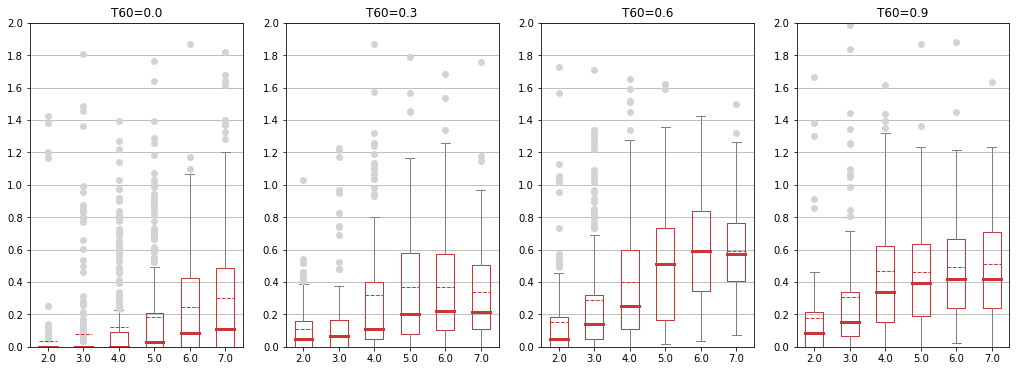

In [262]:
# Print Boxplots
ax, i = init_grid((1,4),(17,6))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

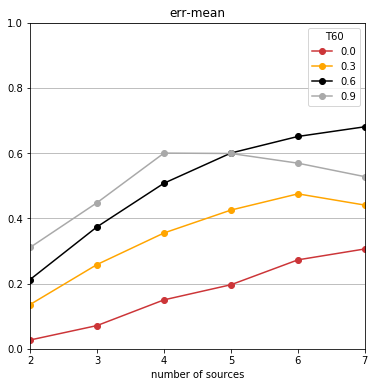

In [268]:
# Print Means in Lineplot
ax, i = init_grid((1,1),(6,6))
cols = ['err-mean']#, 'percent-matched']
axis_param = [[0.2, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = df.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

In [ ]:
# plt.subplots(1,2,figsize=(13,5))
desc = 'em-iterations'
df = matlab2pandas(dirname='em-iterations', save_to=path.join(PATH_ROOT, desc), summary=False)
df = df[df["reflect-order"]==3.0]
print_summary(df)

# dfp = df.pivot_table("err-mean", index=["em"], columns="n-sources", aggfunc='mean').transpose()
# print(dfp)
# dfp.plot(**DEFAULT_LINE_PLOT_ARGS, ax=plt.subplot(1,2,1))

# # Style plot
# style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")
# # adjust_y_axis(0.1, 1, 0)

cols = ['err-mean', 'percent-matched']
for col in cols:
    ax = df.pivot_table(col, index=['n-sources'], columns=['em'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, figsize=[5,4], title=col)
    ax.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x')
    adjust_y_axis(0.1, 1, 0, ax)
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## T60

In [249]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [252]:
# Manipulate Data
var = "T60"
dft = df
dft = dft[dft["reflect-order"]==3]
# dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [253]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources  2.0  3.0  4.0  5.0  6.0  7.0
T60                                    
0.0        300  300  300  300  300  300
0.3        100  100  100  100  100  100
0.6        250  250  250  250  250  250
0.9        100  100  100  100  100  100

MEAN ERROR:
n-sources   2.0   3.0   4.0   5.0   6.0   7.0
T60                                          
0.0        0.03  0.08  0.13  0.18  0.25  0.30
0.3        0.11  0.16  0.32  0.37  0.37  0.34
0.6        0.15  0.29  0.40  0.51  0.60  0.59
0.9        0.18  0.31  0.47  0.46  0.49  0.51


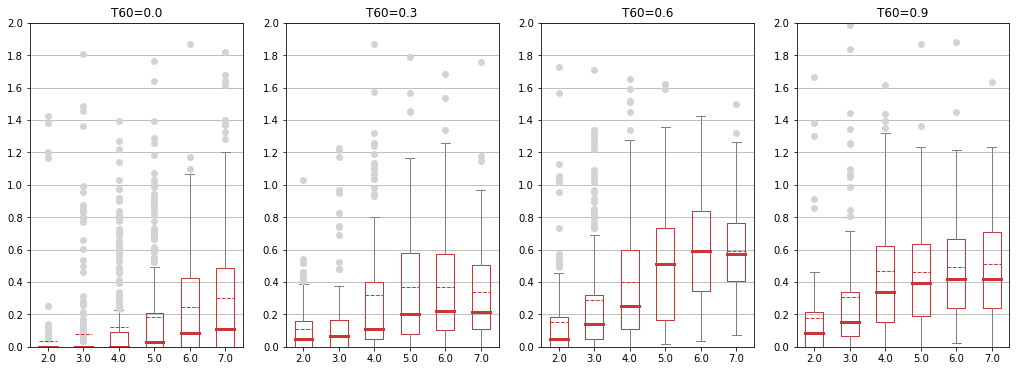

In [262]:
# Print Boxplots
ax, i = init_grid((1,4),(17,6))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

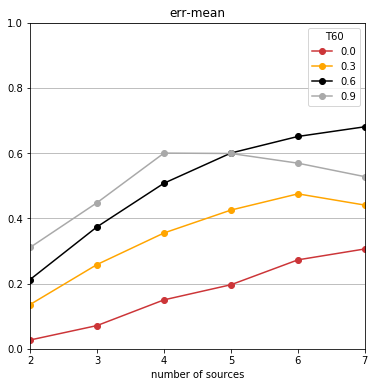

In [268]:
# Print Means in Lineplot
ax, i = init_grid((1,1),(6,6))
cols = ['err-mean']#, 'percent-matched']
axis_param = [[0.2, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = df.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

In [199]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [207]:
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
# dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [208]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["md"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["md"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources  2.0  3.0  4.0  5.0  6.0  7.0
md                                     
0.1        100  100  100  100  100  100
0.3        100  100  100  100  100  100
0.5        300  300  300  300  300  300
1.0        100  100  100  100  100  100

MEAN ERROR:
n-sources       2.0   3.0   4.0   5.0   6.0   7.0
md                                               
0.1        1.53e-02  0.12  0.18  0.18  0.24  0.24
0.3        5.20e-02  0.09  0.15  0.23  0.25  0.20
0.5        3.48e-02  0.08  0.13  0.18  0.25  0.30
1.0        6.33e-03  0.14  0.37  0.45  0.62  0.72


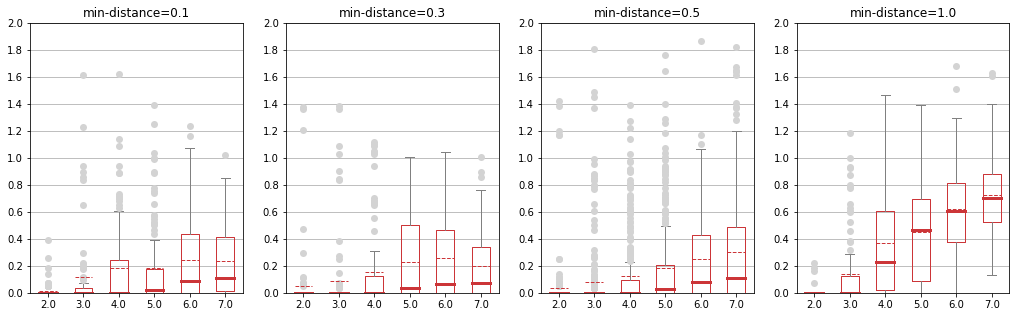

In [211]:
spgrid = (1,4)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,5))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
for md in [.1,.3,.5,1.]:
    dftt = dft[dft["md"]==md]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("min-distance={}".format(md))
        i+=1
    except ValueError:
        continue

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


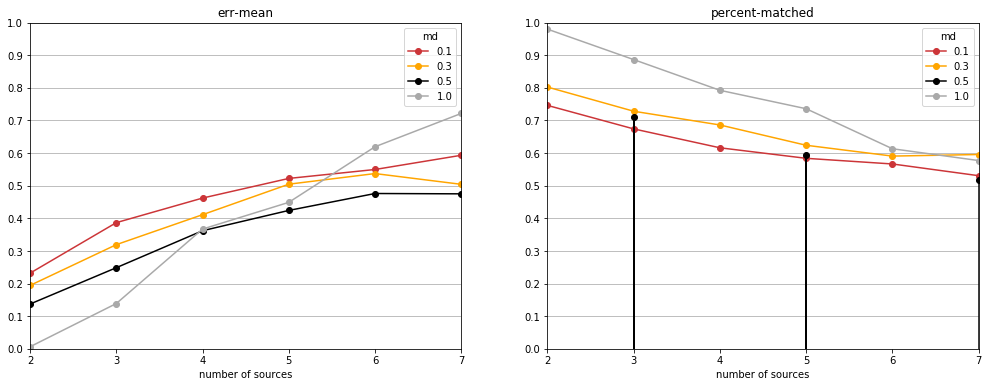

In [217]:
spgrid = (1,2)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
desc = "md"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = df.pivot_table(col, index=['n-sources'], columns=desc, aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
    a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

# Reflect Order

In [121]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [148]:
# Manipulate Data
dft = df
# dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.6]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [149]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["reflect-order"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["reflect-order"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources      2.0  3.0  4.0  5.0  6.0  7.0
reflect-order                              
-1.0           250  250  250  250  250  250
 1.0           250  250  250  250  250  250
 3.0           250  250  250  250  250  250

MEAN ERROR:
n-sources       2.0   3.0   4.0   5.0   6.0   7.0
reflect-order                                    
-1.0           0.23  0.50  0.70  0.80  0.83  0.75
 1.0           0.12  0.17  0.25  0.35  0.43  0.43
 3.0           0.15  0.29  0.40  0.51  0.60  0.59


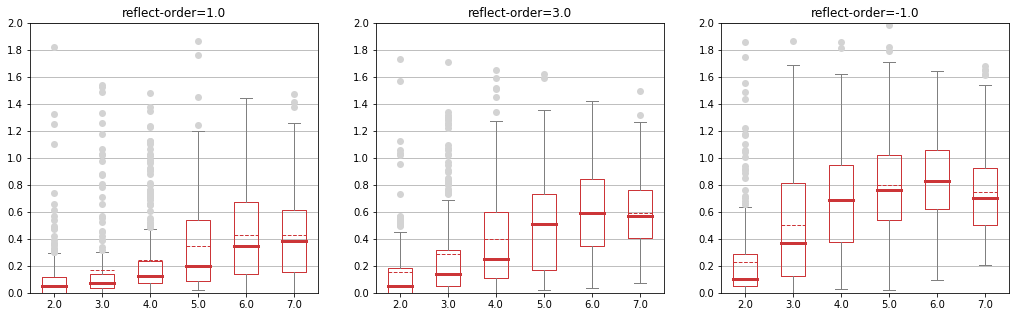

In [198]:
spgrid = (1,3)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,5))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
for ro in [1., 3., -1.]:
    dftt = dft[dft["reflect-order"]==ro]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("reflect-order={}".format(ro))
        i+=1
    except ValueError:
        continue

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


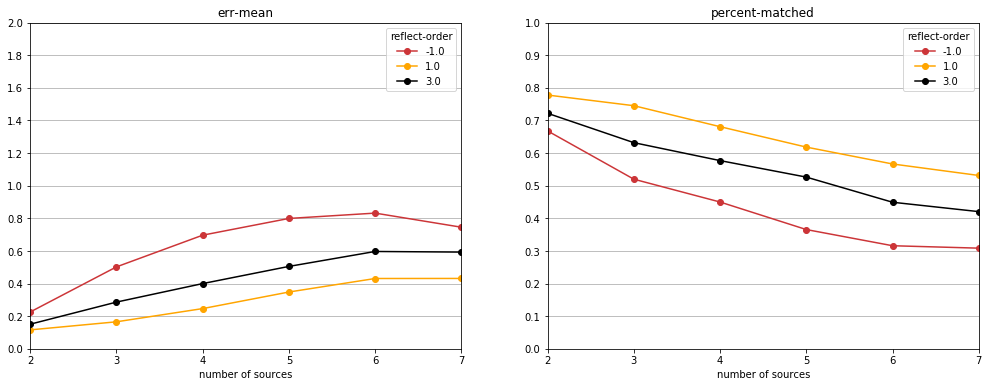

In [197]:
spgrid = (1,2)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
desc = "reflect-order"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = df.pivot_table(col, index=['n-sources'], columns=['reflect-order'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## SNR

In [220]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [246]:
var = "SNR"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
# dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [233]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources  2.0  3.0  4.0  5.0  6.0  7.0
SNR                                    
0.0        100  100  100  100  100  100
5.0        200  200  200  200  200  200
10.0       200  200  200  200  200  200
15.0       200  200  200  200  200  200
30.0       200  200  200  200  200  200

MEAN ERROR:
n-sources   2.0   3.0   4.0   5.0   6.0   7.0
SNR                                          
0.0        0.11  0.16  0.32  0.37  0.37  0.34
5.0        0.17  0.42  0.56  0.58  0.56  0.52
10.0       0.17  0.34  0.45  0.45  0.47  0.46
15.0       0.16  0.25  0.36  0.44  0.46  0.42
30.0       0.13  0.16  0.24  0.32  0.36  0.32


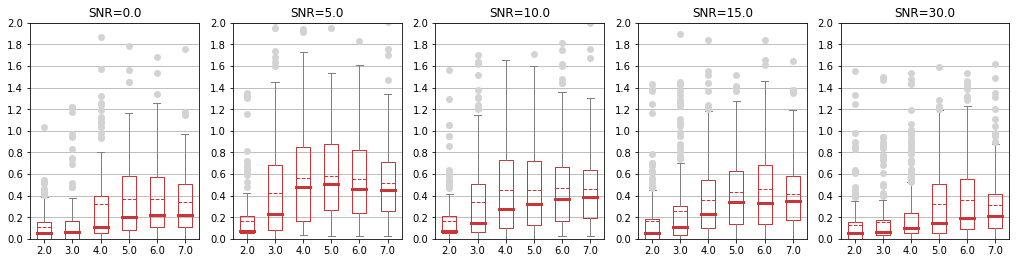

In [236]:
spgrid = (1,5)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,4))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


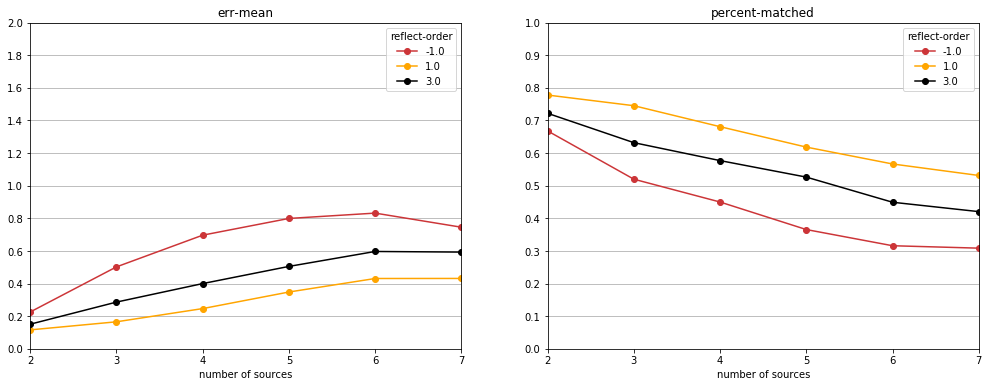

In [197]:
spgrid = (1,2)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
desc = "reflect-order"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = df.pivot_table(col, index=['n-sources'], columns=['reflect-order'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## Guessing at random

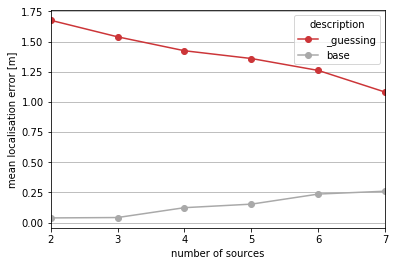

In [247]:
dfs = []
for desc in ['_guessing', 'base']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
df = pd.concat(dfs)

dfp = df.pivot_table("err-mean", index="description", columns="n-sources", aggfunc='mean').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])

style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")

# Wall distance

In [ ]:
dfs = []
for desc in ['base', 'wd']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
df = pd.concat(dfs)

In [ ]:
df = df[df["reflect-order"]==0]
print_summary(df)
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources"))

In [ ]:
plt.subplots(2,2, figsize=(17,17))
ax = list()
for i in range(1,5):
    ax.append(plt.subplot(2,2,i))

plt.subplots_adjust()
i=0
for wd in [1.2, 1.3, 1.5]:
    dft = df[df["wd"]==wd]
    bp = dft.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True)
    style_boxplot(bp)
    plt.title("Wall distance = {}m".format(wd))

# Variance Analysis

In [226]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [227]:
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==10]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
# print_summary(dft)

In [228]:
# Sample Sizes
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["var-val","var-fixed"], aggfunc='count').transpose()
print(dfp)

n-sources            2.0    3.0    4.0    5.0    6.0    7.0
var-val var-fixed                                          
0.1     0.0        100.0  100.0  100.0  100.0  100.0  100.0
        1.0        200.0  200.0  200.0  200.0  200.0  200.0
0.5     0.0         50.0   50.0   50.0    NaN    NaN    NaN
        1.0        200.0  200.0  200.0  200.0  200.0  200.0
1.0     0.0         50.0   50.0   50.0   50.0   50.0   50.0
        1.0        350.0  150.0  150.0    NaN    NaN    NaN
2.0     0.0         50.0   50.0   50.0   50.0   50.0   50.0
        1.0         50.0   50.0   50.0   50.0   50.0   50.0
3.0     1.0        150.0  150.0  150.0  150.0  150.0  150.0
5.0     0.0         50.0   50.0   50.0   50.0   50.0   50.0
        1.0        250.0  250.0  250.0  250.0  250.0  250.0


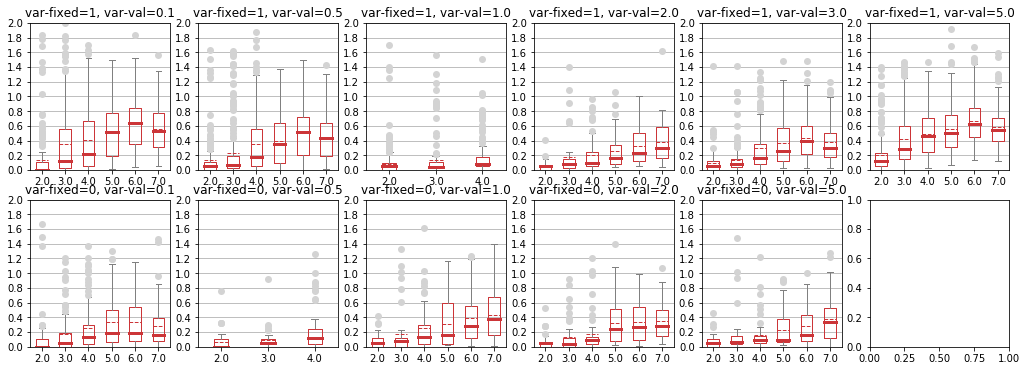

In [229]:
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources", "var", "var-val"))
spgrid = (2,6)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

plt.subplots_adjust()
i=0
for vv, vf in [(0.1,1), (0.5,1), (1.0,1), (2.0,1), (3.0,1),(5.0,1), (0.1, 0), (0.5, 0), (1.0, 0), (2.0, 0), (5.0, 0)]:
    dftt = dft[dft["var-val"]==vv]
    dftt = dftt[dftt["var-fixed"]==vf]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("var-fixed={}, var-val={}".format(vf, vv))
        i+=1
    except ValueError:
        continue
    

# Analyse DataFrame

### Examine Outliers

In [ ]:
# print(pd.concat([df[df["err-mean"]>=1.5].loc[:, "err1":"err7"], df[df["err-mean"]>=1.5].loc[:, "x1":"x7"]], axis=1))
print("ERRORS:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "err1":"err7"]))
print("X-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "x1":"x7est"]))
print("Y-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "y1":"y7est"]))

In [ ]:
# Box Plot
bp = df.boxplot('err-mean', by=["n-sources", "refl-ord"], return_type='both',figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

# Perfect Match Analysis

In [ ]:
dfcp = df.pivot_table("percent-matched", columns="refl-ord", aggfunc='mean').transpose()
dfcp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
style_line_plot(xlabel="number of sources", ylabel="perfect matches", grid="y")

# Significance Analysis

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

# extract err-mean per n_sources
cat = {}
for n in set(df["n-sources"].values):
    cat[str(n)] = df[df['n-sources']==n]['err-mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
fig, ax = plt.subplots(1,3, figsize=(17,  6))
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in set(df["n-sources"].values):
    for i2 in set(df["n-sources"].values):
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")